Deep Convolutional Q-Learning for Pac-Man

Step 1: Installing the required packages and importing the libraries

In [17]:
%pip install "gymnasium" "ale-py==0.9.0" "autorom[accept-rom-license]"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.8 MB/s  0:00:00
  Attempting uninstall: ale-py
    Found existing installation: ale-py 0.11.2
    Uninstalling ale-py-0.11.2:
      Successfully uninstalled ale-py-0.11.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires ale-py>=0.10.1, but you have ale-py 0.9.0 which is incompatible.
dopamine-rl 4.1.2 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.


In [18]:
import sys, subprocess
subprocess.run([sys.executable, "-m", "AutoROM", "--accept-license"])


CompletedProcess(args=['/usr/bin/python3', '-m', 'AutoROM', '--accept-license'], returncode=1)

Setting up the environmen

In [19]:
import gymnasium as gym
import ale_py


gym.register_envs(ale_py)

env = gym.make(
    "ALE/MsPacman-v5",
    obs_type="rgb",
    frameskip=4,
    repeat_action_probability=0.25,
    full_action_space=False,
    render_mode="rgb_array",
)

obs, info = env.reset()

print("Env successfully created!")
print("Observation shape:", env.observation_space.shape)
print("Actions:", env.action_space.n)

number_actions = env.action_space.n
print("number_actions variable set to:", number_actions)


Env successfully created!
Observation shape: (210, 160, 3)
Actions: 9
number_actions variable set to: 9


Initializing the hyperparameters

In [20]:
learning_rate = 5e-4
minibatch_size = 64
discount_factor = 0.99

Preprocessing the frames

In [21]:
from PIL import Image
from torchvision import transforms

def preprocess_frame(frame):
  frame = Image.fromarray(frame)
  preprocess = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])
  return preprocess(frame).unsqueeze(0)

Importing the libraries

In [29]:
import os
import random
import numpy as np

from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset


Creating the architecture of the Neural Network

In [33]:
class Network(nn.Module):

  def __init__(self, action_size, seed = 42):
    super(Network, self).__init__()
    self.seed = torch.manual_seed(seed)
    self.conv1 = nn.Conv2d(3, 32, kernel_size = 8, stride = 4)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 64, kernel_size = 4, stride = 2)
    self.bn2 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1)
    self.bn3 = nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1)
    self.bn4 = nn.BatchNorm2d(128)
    self.fc1 = nn.Linear(10 * 10 * 128, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, action_size)

  def forward(self, state):
    x = F.relu(self.bn1(self.conv1(state)))
    x = F.relu(self.bn2(self.conv2(x)))
    x = F.relu(self.bn3(self.conv3(x)))
    x = F.relu(self.bn4(self.conv4(x)))
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return self.fc3(x)


Implementing the DCQN class

In [34]:
class Agent():

  def __init__(self, action_size):
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.action_size = action_size
    self.local_qnetwork = Network(action_size).to(self.device)
    self.target_qnetwork = Network(action_size).to(self.device)
    self.optimizer = optim.Adam(self.local_qnetwork.parameters(), lr = learning_rate)
    self.memory = deque(maxlen = 10000)

  def step(self, state, action, reward, next_state, done):
    state = preprocess_frame(state)
    next_state = preprocess_frame(next_state)
    self.memory.append((state, action, reward, next_state, done))
    if len(self.memory) > minibatch_size:
      experiences = random.sample(self.memory, k = minibatch_size)
      self.learn(experiences, discount_factor)

  def act(self, state, epsilon = 0.):
    state = preprocess_frame(state).to(self.device)
    self.local_qnetwork.eval()
    with torch.no_grad():
      action_values = self.local_qnetwork(state)
    self.local_qnetwork.train()
    if random.random() > epsilon:
      return np.argmax(action_values.cpu().data.numpy())
    else:
      return random.choice(np.arange(self.action_size))

  def learn(self, experiences, discount_factor):
    states, actions, rewards, next_states, dones = zip(*experiences)
    states = torch.from_numpy(np.vstack(states)).float().to(self.device)
    actions = torch.from_numpy(np.vstack(actions)).long().to(self.device)
    rewards = torch.from_numpy(np.vstack(rewards)).float().to(self.device)
    next_states = torch.from_numpy(np.vstack(next_states)).float().to(self.device)
    dones = torch.from_numpy(np.vstack(dones).astype(np.uint8)).float().to(self.device)
    next_q_targets = self.target_qnetwork(next_states).detach().max(1)[0].unsqueeze(1)
    q_targets = rewards + discount_factor * next_q_targets * (1 - dones)
    q_expected = self.local_qnetwork(states).gather(1, actions)
    loss = F.mse_loss(q_expected, q_targets)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

Initializing the DCQN agent

In [35]:
agent = Agent(number_actions)


In [36]:
import torch

print("torch.cuda.is_available():", torch.cuda.is_available())

print("Agent device:", agent.device)
print("Local Q-network device:", next(agent.local_qnetwork.parameters()).device)
print("Target Q-network device:", next(agent.target_qnetwork.parameters()).device)


torch.cuda.is_available(): True
Agent device: cuda:0
Local Q-network device: cuda:0
Target Q-network device: cuda:0


Training the AI

In [37]:
number_episodes = 5000
maximum_number_timesteps_per_episode = 10000
epsilon_starting_value  = 1.0
epsilon_ending_value  = 0.01
epsilon_decay_value  = 0.995
epsilon = epsilon_starting_value
scores_on_100_episodes = deque(maxlen = 100)

for episode in range(1, number_episodes + 1):
  state, _ = env.reset()
  score = 0
  for t in range(maximum_number_timesteps_per_episode):
    action = agent.act(state, epsilon)
    next_state, reward, done, _, _ = env.step(action)
    agent.step(state, action, reward, next_state, done)
    state = next_state
    score += reward
    if done:
      break
  scores_on_100_episodes.append(score)
  epsilon = max(epsilon_ending_value, epsilon_decay_value * epsilon)
  print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_on_100_episodes)), end = "")
  if episode % 100 == 0:
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_on_100_episodes)))
  if np.mean(scores_on_100_episodes) >= 500.0:
    print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode - 100, np.mean(scores_on_100_episodes)))
    torch.save(agent.local_qnetwork.state_dict(), 'checkpoint.pth')
    break

Episode 100	Average Score: 293.90
Episode 200	Average Score: 374.00
Episode 300	Average Score: 378.10
Episode 400	Average Score: 400.80
Episode 500	Average Score: 475.80
Episode 533	Average Score: 500.70
Environment solved in 433 episodes!	Average Score: 500.70


Visualizing the results

In [38]:
import glob
import io
import base64
import imageio
from IPython.display import HTML, display
from gym.wrappers.monitoring.video_recorder import VideoRecorder

def show_video_of_model(agent, env_name):
    env = gym.make(env_name, render_mode='rgb_array')
    state, _ = env.reset()
    done = False
    frames = []
    while not done:
        frame = env.render()
        frames.append(frame)
        action = agent.act(state)
        state, reward, done, _, _ = env.step(action)
    env.close()
    imageio.mimsave('video.mp4', frames, fps=30)

show_video_of_model(agent, 'ALE/MsPacman-v5')

def show_video():
    mp4list = glob.glob('*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

show_video()

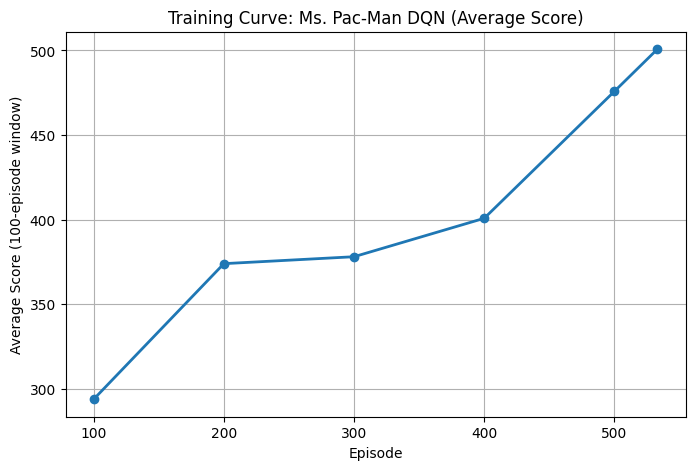

<Figure size 640x480 with 0 Axes>

In [41]:
import matplotlib.pyplot as plt

episodes = [100, 200, 300, 400, 500, 533]
avg_scores = [293.9, 374.0, 378.10, 400.80, 475.80, 500.70]

plt.figure(figsize=(8,5))
plt.plot(episodes, avg_scores, marker='o', linewidth=2)
plt.title("Training Curve: Ms. Pac-Man DQN (Average Score)")
plt.xlabel("Episode")
plt.ylabel("Average Score (100-episode window)")
plt.grid(True)
plt.show()



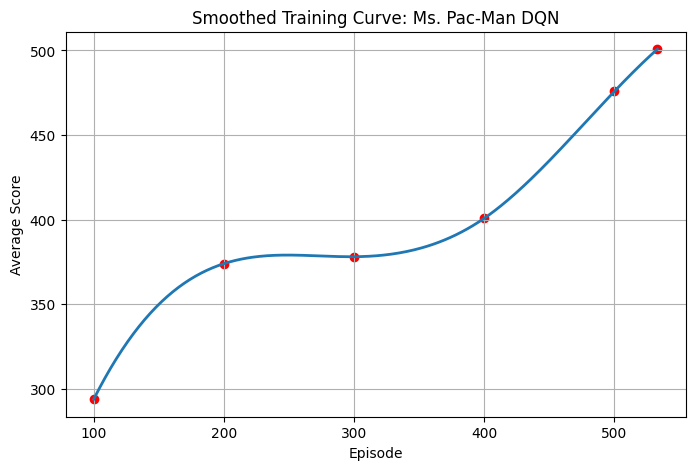

<Figure size 640x480 with 0 Axes>

In [42]:
import numpy as np
from scipy.interpolate import make_interp_spline

# Smooth curve
x = np.array(episodes)
y = np.array(avg_scores)

spline = make_interp_spline(x, y)
x_smooth = np.linspace(x.min(), x.max(), 300)
y_smooth = spline(x_smooth)

plt.figure(figsize=(8,5))
plt.plot(x_smooth, y_smooth, linewidth=2)
plt.scatter(episodes, avg_scores, color='red')
plt.title("Smoothed Training Curve: Ms. Pac-Man DQN")
plt.xlabel("Episode")
plt.ylabel("Average Score")
plt.grid(True)
plt.show()

plt.savefig("training_curve_smoothed.png", dpi=300, bbox_inches='tight')
